# Model evaluation notebook

in this notebook we will evaluate % availability. definitions are:

X = hour, dow, weekend, holiday, is_sunny, caiso, site_id
y = % available (for site)

this will work for all sites.

How will we do train test split?
random 80-20 for now 


In [8]:
import os
if 'models' == os.getcwd().split('/')[-1]: os.chdir('..')
if 'ev_charging' == os.getcwd().split('/')[-1]: print('in the right place!')
else: os.chdir('/Users/varunvenkatesh/Documents/Github/ev_charging')
os.getcwd()

in the right place!


In [1]:
import os
#os.chdir('..')
os.chdir('/Users/varunvenkatesh/Documents/Github/ev_charging')
os.getcwd()

'/Users/varunvenkatesh/Documents/GitHub/ev_charging'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from src.data_preprocessing import  datetime_processing, userinput_processing, holiday_processing, create_all_site_x, create_all_site_y, create_x, update_varuns_x, get_start_end_times

In [3]:
df_c = pd.read_parquet('data/sessions/caltech/').reset_index(drop=True)
df_c = datetime_processing(df_c)
df_c = userinput_processing(df_c)
df_c = holiday_processing(df_c)


df_j = pd.read_parquet('data/sessions/jpl/').reset_index(drop=True)
df_j = datetime_processing(df_j)
df_j = userinput_processing(df_j)
df_j = holiday_processing(df_j)

df_o = pd.read_parquet('data/sessions/office001/').reset_index(drop=True)
df_o = datetime_processing(df_o)
df_o = userinput_processing(df_o)
df_o = holiday_processing(df_o)

cols = list(df_c.columns)
df = pd.concat([df_c[cols], df_j[cols], df_o[cols]], axis=0)

In [4]:
print(f'df is a dataframe comprised of these site ids: {list(df.siteID.unique())}')

df is a dataframe comprised of these site ids: [2, 1, 19]


# Make X and y

In [5]:
start = '2018-05-01'
end = '2021-09-13'
spaceID = 'CA-303'
caiso_fp = 'data/caiso_dataset_5min.csv'
sun_fp = 'data/ct_sr_ss.csv'

In [6]:
X = pd.DataFrame()
sites_df = [df_o,df_c,df_j]
site_ids = [2,1,19]
caiso_fp = 'data/caiso_dataset_5min.csv'


for sdf, id, sun_fp in zip(sites_df, site_ids, ['data/of_sr_ss.csv','data/ct_sr_ss.csv', 'data/jpl_sr_ss.csv'] ):
    start, end = get_start_end_times(sdf)
    tmpx = create_x(start, end, caiso_fp, sun_fp)
    tmpx = update_varuns_x(tmpx, id)
    
    if X.empty:
        X = tmpx
    else:
        X = pd.concat([X, tmpx], axis=0)
    

In [7]:
X['siteID'].value_counts().sum() == X.shape[0]
print(f'there are {X.shape[0]} records')

there are 77715 records


# Deal with covid
we found (graphically) that covid effects start around march 3rd 2020, so we truncated our data to march 1st. Since we did not have dates that contained post covid data, we did not include any charges after 2020-03-01 

In [8]:
x = X[X.index < '2020-03-01']
x.index.max()


Timestamp('2020-02-29 23:00:00+0000', tz='UTC')

In [9]:
cols = list(df_c.columns)
df = pd.concat([df[cols] for df in sites_df], axis=0)
y = create_all_site_y(df, regression=True)

In [10]:
assert X.shape[0] == y.shape[0], 'X and y rows are not equal!'

In [11]:
y = y[y.index < '2020-03-01']
y.index.max()

Timestamp('2020-02-29 23:00:00+0000', tz='UTC')

In [12]:
assert x.shape[0] == y.shape[0], 'forgot to trim y\'s covid!'

In [13]:
y.shape

(37320,)

In [14]:
x.shape

(37320, 29)

# Modeling
In this section we will compare 

- linear regression models
- XGBoost regression, and 
- LSTM

models using the evaluation metric of RMSE

## LR

In [16]:
x.columns
cat_cols = ['dow', 'hour', 'month', 'is_sunny', 'is_holiday','siteID']
num_cols = [col for col in x.columns if col not in cat_cols]
x[cat_cols]

,dow,hour,month,is_sunny,is_holiday,siteID
2019-03-25 00:00:00+00:00,0,0,3,0,False,2
2019-03-25 01:00:00+00:00,0,1,3,0,False,2
2019-03-25 02:00:00+00:00,0,2,3,0,False,2
2019-03-25 03:00:00+00:00,0,3,3,0,False,2
2019-03-25 04:00:00+00:00,0,4,3,0,False,2
...,...,...,...,...,...,...
2020-02-29 19:00:00+00:00,5,19,2,0,False,19
2020-02-29 20:00:00+00:00,5,20,2,0,False,19
2020-02-29 21:00:00+00:00,5,21,2,0,False,19
2020-02-29 22:00:00+00:00,5,22,2,0,False,19


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .2)

cat_cols = ['dow', 'hour', 'month', 'is_sunny', 'is_holiday','siteID']
num_cols = [col for col in x.columns if col not in cat_cols]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')


regression_model = Pipeline(
    steps=[
        ('preprocessing', ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, num_cols),
                ("cat", categorical_transformer, cat_cols),
            ])),
        ('lr', LinearRegression()),
        ]
)

regression_model.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error
print(f'training RMSE: {np.sqrt(mean_squared_error(regression_model.predict(X_train), y_train))}\ntest RMSE    : {np.sqrt(mean_squared_error(regression_model.predict(X_test), y_test))}')
print(f'training R2: {regression_model.score(X_train, y_train)}\ntest R2    : {regression_model.score(X_test, y_test)}')

training RMSE: 0.19237360555088112
test RMSE    : 0.19354066291654182
training R2: 0.5357321143866287
test R2    : 0.5400839707038124


Text(0, 0.5, '% available')

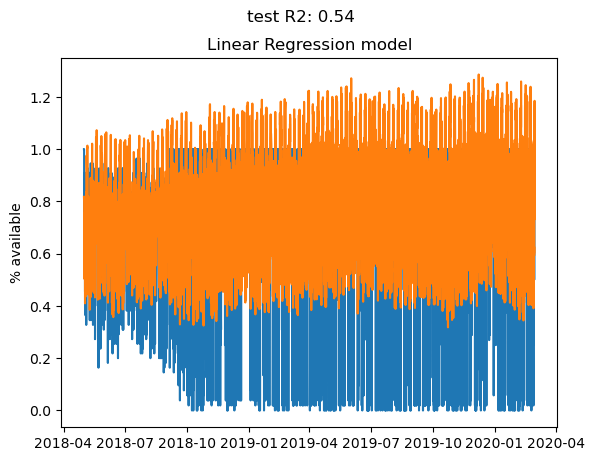

In [18]:
X_test = X_test.sort_index()
y_test = y_test.sort_index()
pred = pd.Series(regression_model.predict(X_test), index=X_test.index)
plt.title('Linear Regression model')
plt.suptitle(f'test R2: {np.round(regression_model.score(X_test, y_test),3)}')
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, pred)
plt.ylabel('% available')

# XGBoost

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .2)

cat_cols = ['dow', 'hour', 'month', 'is_sunny', 'is_holiday','siteID']
num_cols = [col for col in x.columns if col not in cat_cols]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')


regression_model = Pipeline(
    steps=[
        ('preprocessing', ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, num_cols),
                ("cat", categorical_transformer, cat_cols),
            ])),
        ('xgb', XGBRegressor()),
        ]
)

regression_model.fit(X_train, y_train)
print(f'training RMSE: {np.sqrt(mean_squared_error(regression_model.predict(X_train), y_train))}\ntest RMSE    : {np.sqrt(mean_squared_error(regression_model.predict(X_test), y_test))}')
print(f'training loss: {regression_model.score(X_train, y_train)}\ntest loss    : {regression_model.score(X_test, y_test)}')

training RMSE: 0.07685925625300576
test RMSE    : 0.10064962384629918
training loss: 0.9262921362950486
test loss    : 0.8728945798828784


Text(0, 0.5, '% available')

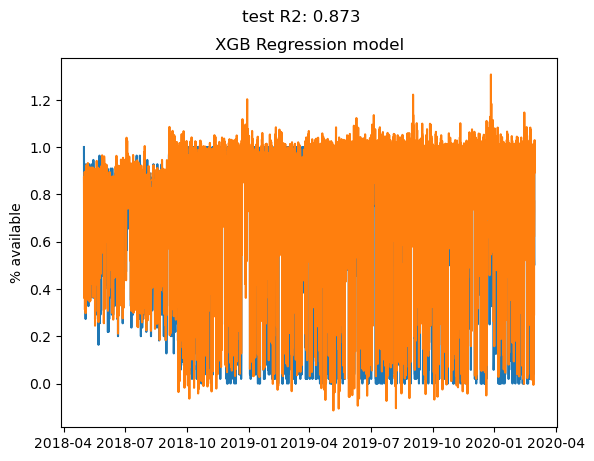

In [20]:
X_test = X_test.sort_index()
y_test = y_test.sort_index()
pred = pd.Series(regression_model.predict(X_test), index=X_test.index)
plt.title('XGB Regression model')
plt.suptitle(f'test R2: {np.round(regression_model.score(X_test, y_test),3)}')
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, pred)
plt.ylabel('% available')

# LSTM

In [37]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
tf.random.set_seed(42)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .2)

cat_cols = ['dow', 'hour', 'month', 'is_sunny', 'is_holiday','siteID']
num_cols = [col for col in x.columns if col not in cat_cols]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

X_train_1 = pd.DataFrame(numeric_transformer.fit_transform(X_train[num_cols]))
X_train_2 = pd.DataFrame(categorical_transformer.fit_transform(X_train[cat_cols]))
X_train_enc = pd.concat([X_train_1, X_train_2], axis=1)
X_train_enc = np.reshape(X_train_enc.values.astype(float), (X_train_enc.shape[0], 1, X_train_enc.shape[1]))
def create_lstm():
    model = Sequential()
    model.add(LSTM(7, input_shape=(1, X_train_enc.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(7, activation='selu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

regression_model = Pipeline(
    steps=[
        ('preprocessing', ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, num_cols),
                ("cat", categorical_transformer, cat_cols),
            ])),
        ('lstm', create_lstm()),
        ]
)
regression_model = create_lstm()
regression_model.fit(X_train_enc, y_train, epochs=10, batch_size=8, verbose=2)

#print(f'training RMSE: {np.sqrt(mean_squared_error(regression_model.predict(X_train), y_train))}\ntest RMSE    : {np.sqrt(mean_squared_error(regression_model.predict(X_test), y_test))}')
#print(f'training loss: {regression_model.score(X_train, y_train)}\ntest loss    : {regression_model.score(X_test, y_test)}')

Epoch 1/10
3732/3732 - 52s - loss: 0.0495 - 52s/epoch - 14ms/step
Epoch 2/10
3732/3732 - 40s - loss: 0.0180 - 40s/epoch - 11ms/step
Epoch 3/10
3732/3732 - 39s - loss: 0.0154 - 39s/epoch - 10ms/step
Epoch 4/10
3732/3732 - 38s - loss: 0.0142 - 38s/epoch - 10ms/step
Epoch 5/10
3732/3732 - 35s - loss: 0.0136 - 35s/epoch - 9ms/step
Epoch 6/10
3732/3732 - 26s - loss: 0.0128 - 26s/epoch - 7ms/step
Epoch 7/10
3732/3732 - 31s - loss: 0.0123 - 31s/epoch - 8ms/step
Epoch 8/10
3732/3732 - 37s - loss: 0.0118 - 37s/epoch - 10ms/step
Epoch 9/10
3732/3732 - 27s - loss: 0.0116 - 27s/epoch - 7ms/step
Epoch 10/10
3732/3732 - 18s - loss: 0.0114 - 18s/epoch - 5ms/step


In [40]:
X_test = X_test.sort_index()
X_test_1 = pd.DataFrame(numeric_transformer.transform(X_test[num_cols]))
X_test_2 = pd.DataFrame(categorical_transformer.transform(X_test[cat_cols]))
X_test_enc = pd.concat([X_test_1, X_test_2], axis=1)
X_test_enc = np.reshape(X_test_enc.values.astype(float), (X_test_enc.shape[0], 1, X_test_enc.shape[1]))

In [39]:
print(f'training RMSE: {np.sqrt(mean_squared_error(regression_model.predict(X_train_enc), y_train))}\ntest RMSE    : {np.sqrt(mean_squared_error(regression_model.predict(X_test_enc), y_test))}')
print(f'training loss: {regression_model.score(X_train_enc, y_train)}\ntest loss    : {regression_model.score(X_test_enc, y_test)}')

234/234 [==============================] - 6s 14ms/step
training RMSE: 0.0926801788914463
test RMSE    : 0.09345605761988095


AttributeError: 'Sequential' object has no attribute 'score'

234/234 [==============================] - 2s 8ms/step


Text(0, 0.5, '% available')

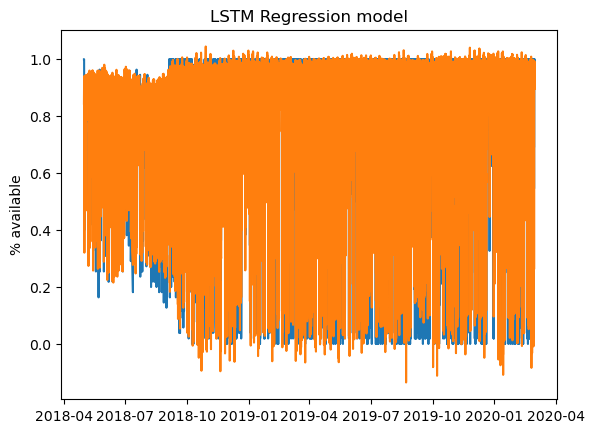

In [42]:
y_test = y_test.sort_index()
pred = regression_model.predict(X_test_enc)
plt.title('LSTM Regression model')
#plt.suptitle(f'test R2: {np.round(regression_model.score(X_test, y_test),3)}')
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, pred)
plt.ylabel('% available')